# Packages

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from numpy import array
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Amazon_Products.csv")

data.dropna(subset=['Body'], inplace=True)
data.dropna(subset=['Title'], inplace=True)


Mounted at /content/drive


In [ ]:
data['Sentiment'] = data['Rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
data['Text'] = data['Body'] + data['Title']
data['id'] = np.arange(data.shape[0])
data.head(5)

,ASIN,Product,Title,Rating,Date,Body,Brand,Sentiment,Text,id
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess,positive,This is a brilliant product...I'd had the Tefa...,0
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess,negative,"I love mine, pity the non stick coating comes ...",1
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess,negative,Thought this product would be great but had it...,2
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares,positive,This is my second one of these the 1st lasted ...,3
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares,positive,Great itemGreat item,4


# EDA

In [ ]:
data.isnull().values.any()

False

<Axes: xlabel='Sentiment', ylabel='count'>

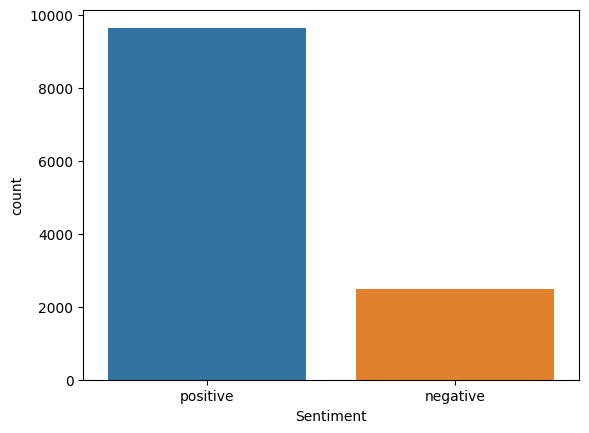

In [ ]:
#distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiment', data=data)

# Pre-processing

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    #pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    #sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on Amazon_reviews
X = []
sentences = list(data['Text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:

y = data['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train shape",len(X_train))
print("x_test shape",len(X_test))
print("y_train shape",len(y_train))
print("y_test shape",len(y_test))

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

x_train shape 9694
x_test shape 2424
y_train shape 9694
y_test shape 2424


In [ ]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

9281

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Word Embeddings using GloVe

In [ ]:
# source: https://nlp.stanford.edu/projects/glove/
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(9281, 100)

# Neural Network architecture

In [ ]:
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          928100    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 938,101
Trainable params: 10,001
Non-trainable params: 928,100
_________________________________________________________________
None


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

Epoch 1/6
61/61 [==============================] - 5s 6ms/step - loss: 0.5723 - acc: 0.7239 - val_loss: 0.5293 - val_acc: 0.7555
Epoch 2/6
61/61 [==============================] - 0s 3ms/step - loss: 0.3996 - acc: 0.8548 - val_loss: 0.4375 - val_acc: 0.8221
Epoch 3/6
61/61 [==============================] - 0s 3ms/step - loss: 0.3321 - acc: 0.8930 - val_loss: 0.3786 - val_acc: 0.8510
Epoch 4/6
61/61 [==============================] - 0s 3ms/step - loss: 0.2880 - acc: 0.9090 - val_loss: 0.3087 - val_acc: 0.8917
Epoch 5/6
61/61 [==============================] - 0s 3ms/step - loss: 0.2593 - acc: 0.9229 - val_loss: 0.2947 - val_acc: 0.8948
Epoch 6/6
61/61 [==============================] - 0s 3ms/step - loss: 0.2369 - acc: 0.9317 - val_loss: 0.2892 - val_acc: 0.8963


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 0s 2ms/step - loss: 0.2883 - acc: 0.9022


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2883240282535553
Test Accuracy: 0.9022276997566223


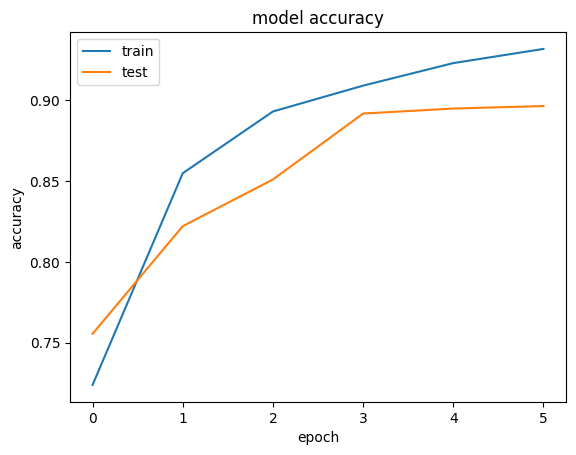

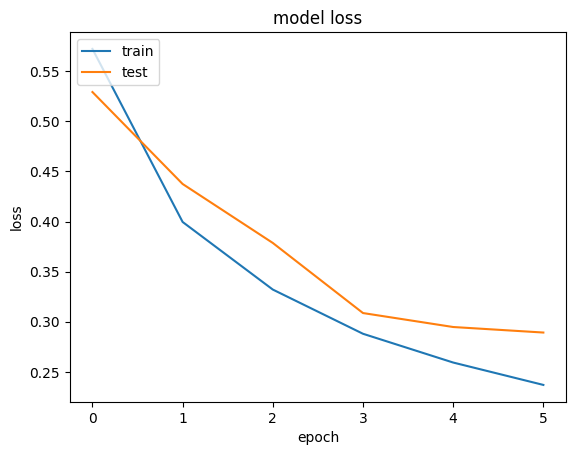

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D
import keras
import numpy as np
np.random.seed(121)

In [ ]:
# Hyper parameter tunng ~ 3 hrs
# Neural Network architecture
#lr = 5e-5
#optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

ls = []
cnn_result_dict = {}
cnn_iteration_dict = {}
best_valid_acc = float()
best_valid_loss = float()
iteration = 1

for filter in (16,64, 128):
  for kernel_size in (8,16):
    for layer_activation in ('relu','sigmoid'):  
      for dense_layer in (1,10, 50):
        for dense_activation in ('relu','sigmoid'):
          for lr in (1e-5,3e-5,5e-5):
            for batch in (64, 128):
              try:
                cnn_model = Sequential()
                embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
                cnn_model.add(embedding_layer)
                cnn_model.add(Conv1D(filter, kernel_size, activation=layer_activation))
                cnn_model.add(GlobalMaxPooling1D())
                cnn_model.add(Dense(dense_layer, activation=dense_activation))
                cnn_model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['acc'])
                cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=batch, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])
                for acc,loss in zip(cnn_model_history.history['val_acc'],cnn_model_history.history['val_loss']):
                  if acc > best_valid_acc or loss < best_valid_loss:
                    best_valid_acc = acc
                    best_valid_loss = loss
                cnn_result_dict[iteration] = {'filter': filter, 'kernel_size': kernel_size, 'layer_activation': layer_activation, 'dense_layer': dense_layer, 'dense_activation': dense_activation, 'lr': lr, 'batch_size': batch, 'Validation_acc': best_valid_acc, 'Validation_lss': best_valid_loss} 
                print(f"With filter = {filter}, kernel_size = {kernel_size}, layer_activation = {layer_activation}, dense_layer = {dense_layer}, dense_activation = {dense_activation}, lr = {lr}, batch_size = {batch} done!!!")
                keras.backend.clear_session()
                iteration += 1
              except:
                continue

Streaming output truncated to the last 5000 lines.
Epoch 19/40
61/61 [==============================] - 1s 14ms/step - loss: 0.6471 - acc: 0.5404 - val_loss: 0.6815 - val_acc: 0.5642
Epoch 20/40
61/61 [==============================] - 1s 15ms/step - loss: 0.6431 - acc: 0.5720 - val_loss: 0.6762 - val_acc: 0.5792
Epoch 21/40
61/61 [==============================] - 1s 15ms/step - loss: 0.6392 - acc: 0.5821 - val_loss: 0.6696 - val_acc: 0.6034
Epoch 22/40
61/61 [==============================] - 1s 14ms/step - loss: 0.6354 - acc: 0.6121 - val_loss: 0.6660 - val_acc: 0.6086
Epoch 23/40
61/61 [==============================] - 1s 14ms/step - loss: 0.6317 - acc: 0.6107 - val_loss: 0.6622 - val_acc: 0.6147
Epoch 24/40
61/61 [==============================] - 1s 14ms/step - loss: 0.6281 - acc: 0.6161 - val_loss: 0.6582 - val_acc: 0.6184
Epoch 25/40
61/61 [==============================] - 1s 15ms/step - loss: 0.6246 - acc: 0.6313 - val_loss: 0.6536 - val_acc: 0.6271
Epoch 26/40
61/61 [======

In [ ]:
#Create json file and move to drive
import json

file_path = "cnn_result_dict.json"

with open(file_path, "w") as json_file:
    json.dump(cnn_result_dict, json_file)

!cp '/content/cnn_result_dict.json' '/content/drive/MyDrive/cnn_result_dict.json'

In [ ]:
for k,v in cnn_result_dict.items():
  print(v)
  

{'filter': 16, 'kernel_size': 8, 'layer_activation': 'relu', 'dense_layer': 1, 'dense_activation': 'relu', 'lr': 1e-05, 'batch_size': 64, 'Validation_acc': 0.4631253182888031, 'Validation_lss': 3.281038284301758}
{'filter': 16, 'kernel_size': 8, 'layer_activation': 'relu', 'dense_layer': 1, 'dense_activation': 'relu', 'lr': 1e-05, 'batch_size': 128, 'Validation_acc': 0.4631253182888031, 'Validation_lss': 3.281038284301758}
{'filter': 16, 'kernel_size': 8, 'layer_activation': 'relu', 'dense_layer': 1, 'dense_activation': 'relu', 'lr': 3e-05, 'batch_size': 64, 'Validation_acc': 0.6328004002571106, 'Validation_lss': 1.6841351985931396}
{'filter': 16, 'kernel_size': 8, 'layer_activation': 'relu', 'dense_layer': 1, 'dense_activation': 'relu', 'lr': 3e-05, 'batch_size': 128, 'Validation_acc': 0.4775657653808594, 'Validation_lss': 1.9736348390579224}
{'filter': 16, 'kernel_size': 8, 'layer_activation': 'relu', 'dense_layer': 1, 'dense_activation': 'relu', 'lr': 5e-05, 'batch_size': 64, 'Valid

In [ ]:
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = {   
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          928100    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 992,357
Trainable params: 64,257
Non-trainable params: 928,100
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

Epoch 1/50
61/61 [==============================] - 6s 82ms/step - loss: 0.4880 - acc: 0.7542 - val_loss: 0.3830 - val_acc: 0.8350
Epoch 2/50
61/61 [==============================] - 5s 79ms/step - loss: 0.2997 - acc: 0.8852 - val_loss: 0.2896 - val_acc: 0.8871
Epoch 3/50
61/61 [==============================] - 4s 72ms/step - loss: 0.2170 - acc: 0.9297 - val_loss: 0.2110 - val_acc: 0.9324
Epoch 4/50
61/61 [==============================] - 5s 85ms/step - loss: 0.1637 - acc: 0.9572 - val_loss: 0.1605 - val_acc: 0.9556
Epoch 5/50
61/61 [==============================] - 4s 73ms/step - loss: 0.1280 - acc: 0.9697 - val_loss: 0.1721 - val_acc: 0.9438
Epoch 6/50
61/61 [==============================] - 4s 74ms/step - loss: 0.0977 - acc: 0.9819 - val_loss: 0.1693 - val_acc: 0.9495
Epoch 7/50
61/61 [==============================] - 6s 92ms/step - loss: 0.0768 - acc: 0.9870 - val_loss: 0.1343 - val_acc: 0.9587
Epoch 8/50
61/61 [==============================] - 4s 72ms/step - loss: 0.0622 - a

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 1s 8ms/step - loss: 0.0918 - acc: 0.9699


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0917508453130722
Test Accuracy: 0.9698845148086548


In [ ]:
Y_pred_prob = cnn_model.predict(X_test)

y_pred = (Y_pred_prob > 0.5).astype(int)

C_M = confusion_matrix(y_test, y_pred)

76/76 [==============================] - 1s 12ms/step


76/76 [==============================] - 1s 14ms/step
test_accuracy: 0.972


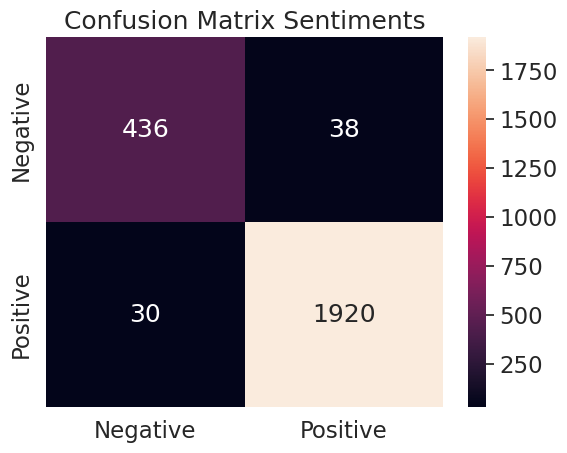

In [ ]:
Y_pred_prob = cnn_model.predict(X_test)

y_pred = (Y_pred_prob > 0.5).astype(int)

C_M = confusion_matrix(y_test, y_pred)

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix Sentiments")

acc = accuracy_score(y_test, y_pred)

print('test_accuracy: %.3f' % (acc))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_CNN = accuracy_score(y_test, y_pred)
Balanced_accuracy_cnn = balanced_accuracy_score(y_test, y_pred)
Precision_CNN = precision_score(y_test, y_pred,average = 'weighted')
Recall_CNN = recall_score(y_test, y_pred,average = 'weighted')
F1_score_CNN = f1_score(y_test, y_pred,average = 'weighted') #, average='macro'
sensitivity_CNN = Recall_CNN
specificity_CNN =  C_M[0][0] / (C_M[0][0] + C_M[0][1])
 


In [ ]:
print(Accuracy_CNN)
print(Balanced_accuracy_cnn)
print(Precision_CNN)
print(Recall_CNN)
print(F1_score_CNN)
print(sensitivity_CNN)
print(specificity_CNN)

0.9698844884488449
0.9453521583901331
0.9696152399506387
0.9698844884488449
0.9696748863045991
0.9698844884488449
0.9050632911392406


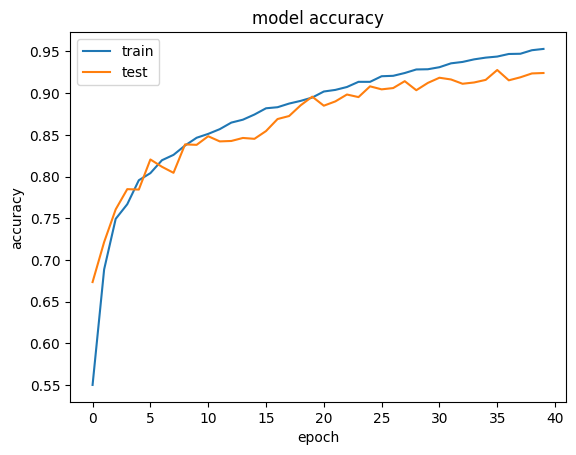

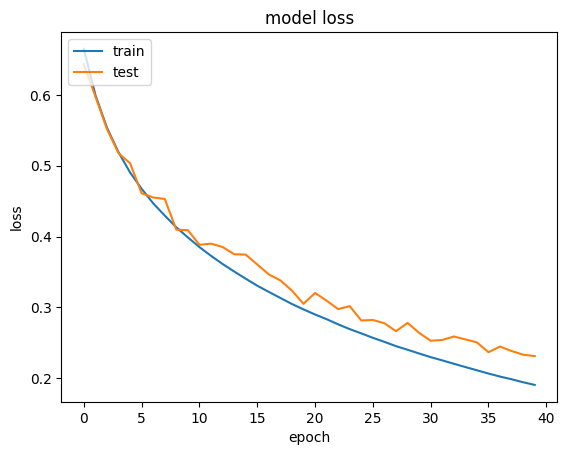

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later
cnn_model.save(f"./drive/MyDrive/c1_cnn_model_acc_{round(score[1], 3)}_optimizer.h5", save_format='h5')

In [ ]:
#Loading cnn_model with best weights 
from tensorflow.keras.models import load_model

cnn_model = load_model('/content/drive/MyDrive/c1_cnn_model_acc_0.97.h5')

# Recurrent Neural Network (LSTM)


In [ ]:
from keras.layers import LSTM
import numpy as np
np.random.seed(121)

In [ ]:
# Hyper parameter tunng ~ 3 hrs
# Neural Network architecture
#lr = 5e-5
#optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

ls = []
lstm_result_dict = {}
best_valid_acc = float()
best_valid_loss = float()
iteration = 1

for units in (16,64, 128): 
  for dense_layer in (1,10, 50):
    for dense_activation in ('relu','sigmoid'):
      for lr in (1e-5,3e-5,5e-5):
        for batch in (64, 128):
          try:
            lstm_model = Sequential()
            embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
            lstm_model.add(embedding_layer)
            lstm_model.add(LSTM(units))
            lstm_model.add(Dense(1, activation='sigmoid'))
            lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['acc'])
            lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])
            for acc,loss in zip(lstm_model_history.history['val_acc'],lstm_model_history.history['val_loss']):
              if acc > best_valid_acc or loss < best_valid_loss:
                best_valid_acc = acc
                best_valid_loss = loss
            lstm_result_dict[iteration] = {'LSTM_units': units, 'dense_layer': dense_layer, 'dense_activation': dense_activation, 'lr': lr, 'batch_size': batch, 'Validation_acc': best_valid_acc, 'Validation_lss': best_valid_loss} 
            print(f"With LSTM_units = {units}, dense_layer = {dense_layer}, dense_activation = {dense_activation}, lr = {lr}, batch_size = {batch} done!!!")
            keras.backend.clear_session()
            iteration += 1
          except:
            continue

Epoch 1/40
61/61 [==============================] - 5s 47ms/step - loss: 0.6984 - acc: 0.2729 - val_loss: 0.6872 - val_acc: 0.2733
Epoch 2/40
61/61 [==============================] - 2s 35ms/step - loss: 0.6980 - acc: 0.2651 - val_loss: 0.6876 - val_acc: 0.2713
Epoch 3/40
61/61 [==============================] - 2s 35ms/step - loss: 0.6976 - acc: 0.2620 - val_loss: 0.6880 - val_acc: 0.2641
Epoch 4/40
61/61 [==============================] - 2s 34ms/step - loss: 0.6972 - acc: 0.2557 - val_loss: 0.6883 - val_acc: 0.2610
Epoch 5/40
61/61 [==============================] - 2s 34ms/step - loss: 0.6969 - acc: 0.2545 - val_loss: 0.6886 - val_acc: 0.2635
Epoch 6/40
61/61 [==============================] - 2s 34ms/step - loss: 0.6966 - acc: 0.2522 - val_loss: 0.6890 - val_acc: 0.2579
Epoch 6: early stopping
With LSTM_units = 16, dense_layer = 1, dense_activation = relu, lr = 1e-05, batch_size = 64 done!!!
Epoch 1/40
61/61 [==============================] - 4s 42ms/step - loss: 0.6949 - acc: 0.6

In [ ]:
#Create json file and move to drive
import json

file_path = "lstm_result_dict.json"

with open(file_path, "w") as json_file:
    json.dump(lstm_result_dict, json_file)

!cp '/content/lstm_result_dict.json' '/content/drive/MyDrive/lstm_result_dict.json'


In [ ]:
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(64))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          928100    
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 970,405
Trainable params: 42,305
Non-trainable params: 928,100
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

Epoch 1/40
61/61 [==============================] - 9s 148ms/step - loss: 0.2222 - acc: 0.9265 - val_loss: 0.2814 - val_acc: 0.9025
Epoch 2/40
61/61 [==============================] - 9s 150ms/step - loss: 0.2217 - acc: 0.9237 - val_loss: 0.2327 - val_acc: 0.9304
Epoch 3/40
61/61 [==============================] - 9s 142ms/step - loss: 0.1529 - acc: 0.9488 - val_loss: 0.2299 - val_acc: 0.9278
Epoch 4/40
61/61 [==============================] - 8s 129ms/step - loss: 0.1275 - acc: 0.9620 - val_loss: 0.2288 - val_acc: 0.9350
Epoch 5/40
61/61 [==============================] - 9s 154ms/step - loss: 0.1156 - acc: 0.9678 - val_loss: 0.2116 - val_acc: 0.9360
Epoch 6/40
61/61 [==============================] - 9s 144ms/step - loss: 0.1142 - acc: 0.9696 - val_loss: 0.2029 - val_acc: 0.9412
Epoch 7/40
61/61 [==============================] - 8s 137ms/step - loss: 0.1167 - acc: 0.9672 - val_loss: 0.2134 - val_acc: 0.9391
Epoch 8/40
61/61 [==============================] - 9s 146ms/step - loss: 0.

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)  

76/76 [==============================] - 4s 40ms/step - loss: 0.1780 - acc: 0.9625


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.17798708379268646
Test Accuracy: 0.9624587297439575


In [ ]:
Y_pred_prob = lstm_model.predict(X_test)

y_pred = (Y_pred_prob > 0.5).astype(int)

C_M = confusion_matrix(y_test, y_pred)

76/76 [==============================] - 4s 52ms/step


76/76 [==============================] - 2s 25ms/step
test_accuracy: 0.950


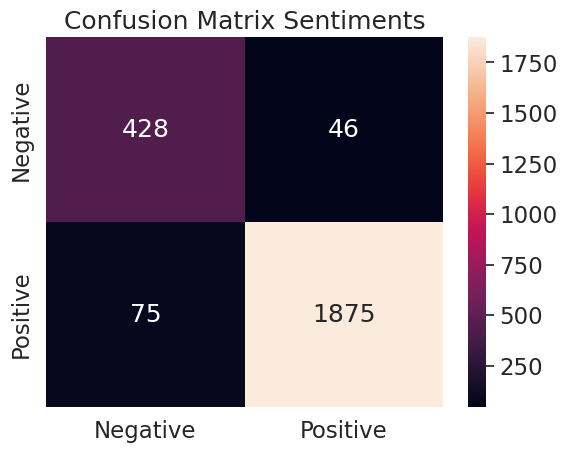

In [ ]:
Y_pred_prob = lstm_model.predict(X_test)

y_pred = (Y_pred_prob > 0.5).astype(int)

C_M = confusion_matrix(y_test, y_pred)

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix Sentiments")

acc = accuracy_score(y_test, y_pred)

print('test_accuracy: %.3f' % (acc))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_LSTM = accuracy_score(y_test, y_pred)
Balanced_accuracy_LSTM = balanced_accuracy_score(y_test, y_pred)
Precision_LSTM = precision_score(y_test, y_pred,average = 'weighted')
Recall_LSTM = recall_score(y_test, y_pred,average = 'weighted')
F1_score_LSTM = f1_score(y_test, y_pred,average = 'weighted') 
sensitivity_LSTM = Recall_LSTM
specificity_LSTM =  C_M[0][0] / (C_M[0][0] + C_M[0][1])
 

print(Accuracy_LSTM)
print(Balanced_accuracy_LSTM)
print(Precision_LSTM)
print(Recall_LSTM)
print(F1_score_LSTM)
print(sensitivity_LSTM)
print(specificity_LSTM)

0.9624587458745875
0.9383414475819539
0.9623202722662944
0.9624587458745875
0.9623832538437331
0.9624587458745875
0.8987341772151899


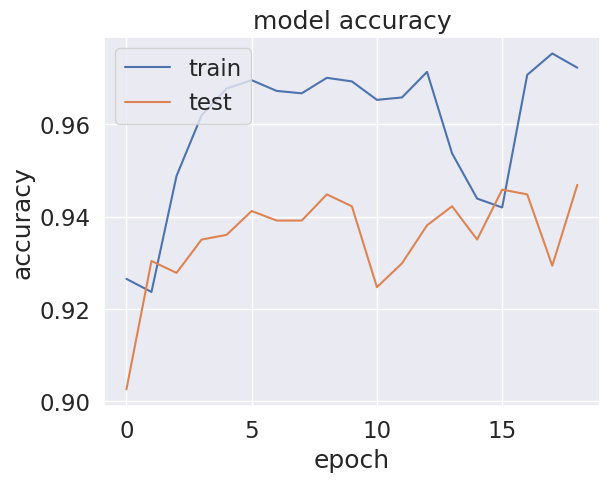

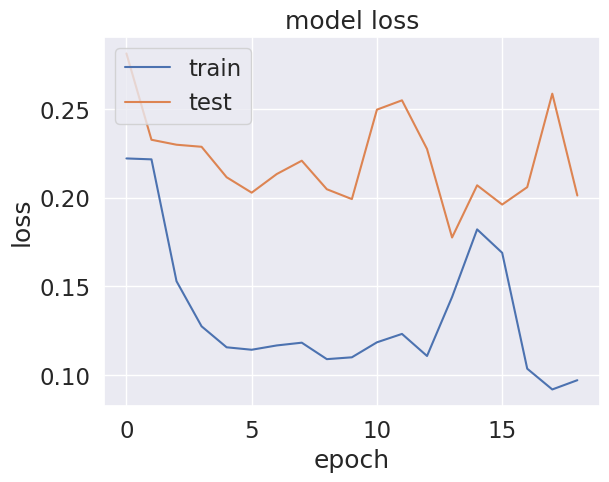

In [ ]:
# Model Performance Charts
import seaborn as sn
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
# Saving the model as a h5 file for possible use later
lstm_model.save(f"./drive/MyDrive/c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# CNN-LSTM

In [ ]:
from keras.layers import LSTM,Conv1D,MaxPooling1D
import numpy as np
np.random.seed(121)

In [ ]:
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added 
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Neural Network architecture

cnn_lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

cnn_lstm_model.add(embedding_layer)
cnn_lstm_model.add(Conv1D(128, 3, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
#cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(LSTM(64))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_lstm_model.summary())



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 100)          928100    
                                                                 
 conv1d_12 (Conv1D)          (None, 98, 128)           38528     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 128)          0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,016,101
Trainable params: 88,001
Non-trainable params: 928,100
________________________________________

In [ ]:
# Model training

cnn_lstm_model_history = cnn_lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

Epoch 1/40
61/61 [==============================] - 1s 10ms/step - loss: 0.6235 - acc: 0.7471 - val_loss: 0.4003 - val_acc: 0.7849
Epoch 2/40
61/61 [==============================] - 0s 7ms/step - loss: 0.3510 - acc: 0.8422 - val_loss: 0.2878 - val_acc: 0.9015
Epoch 3/40
61/61 [==============================] - 0s 8ms/step - loss: 0.2326 - acc: 0.9177 - val_loss: 0.2922 - val_acc: 0.8969
Epoch 4/40
61/61 [==============================] - 0s 8ms/step - loss: 0.1088 - acc: 0.9669 - val_loss: 0.2034 - val_acc: 0.9340
Epoch 5/40
61/61 [==============================] - 0s 7ms/step - loss: 0.0850 - acc: 0.9769 - val_loss: 0.1576 - val_acc: 0.9562
Epoch 6/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0702 - acc: 0.9825 - val_loss: 0.2092 - val_acc: 0.9453
Epoch 7/40
61/61 [==============================] - 1s 8ms/step - loss: 0.0637 - acc: 0.9836 - val_loss: 0.1778 - val_acc: 0.9546
Epoch 8/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0915 - acc: 0.9

In [ ]:
# Predictions on the Test Set

score = cnn_lstm_model.evaluate(X_test, y_test, verbose=1)

76/76 [==============================] - 0s 4ms/step - loss: 0.1717 - acc: 0.9521


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 0.17172713577747345
Test Accuracy: 0.9521452188491821


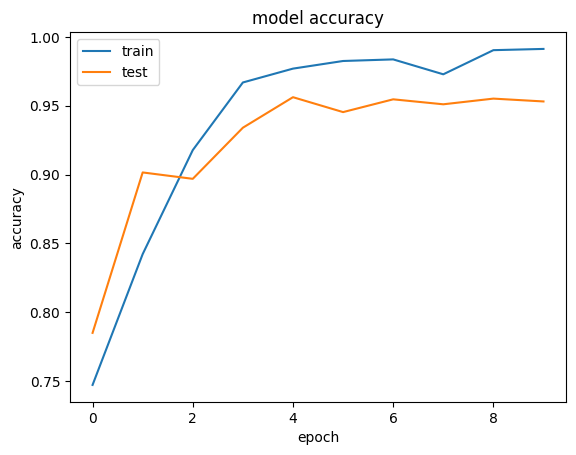

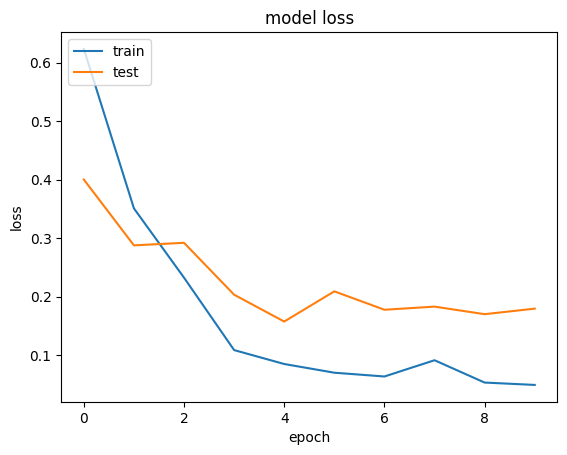

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_lstm_model_history.history['acc'])
plt.plot(cnn_lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_lstm_model_history.history['loss'])
plt.plot(cnn_lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


In [ ]:
# Saving the model as a h5 file for possible use later
cnn_lstm_model.save(f"./drive/MyDrive/c1_cnn_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Testing CNN-LSTM model on New Dataset

In [ ]:
#Loading LSTM Model
from tensorflow.keras.models import load_model

cnn_lstm_model = load_model('/content/drive/MyDrive/c1_cnn_lstm_model_acc_0.952.h5')

In [ ]:
sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews['Srn'] = np.arange(sample_reviews.shape[0])

sample_reviews.head(6)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,Srn
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",2
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",3
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",4
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht...",5


In [ ]:
# Pre-processing text

unseen_reviews = sample_reviews['reviews.text'] + sample_reviews['reviews.title']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

In [ ]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = cnn_lstm_model.predict(unseen_padded)

sample_reviews['Predicted Sentiments_cnn_lstm'] = np.round((unseen_sentiments*10)/2,1)


df_cnn_lstm_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_cnn_lstm']]

df_cnn_lstm_prediction.head(10)

df_cnn_lstm_prediction['reviews.rating_sentiment'] = df_cnn_lstm_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_lstm_prediction['cnn_lstm_Predicted.rating_sentiment'] = df_cnn_lstm_prediction['Predicted Sentiments_cnn_lstm'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_lstm_prediction['cnn_lstm_vs_actual'] = df_cnn_lstm_prediction['reviews.rating_sentiment'] == df_cnn_lstm_prediction['cnn_lstm_Predicted.rating_sentiment']

df_cnn_lstm_prediction.head(5)


886/886 [==============================] - 3s 3ms/step


,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_cnn_lstm,reviews.rating_sentiment,cnn_lstm_Predicted.rating_sentiment,cnn_lstm_vs_actual
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0,positive,negative,False
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.4,positive,positive,True
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True


<Axes: >

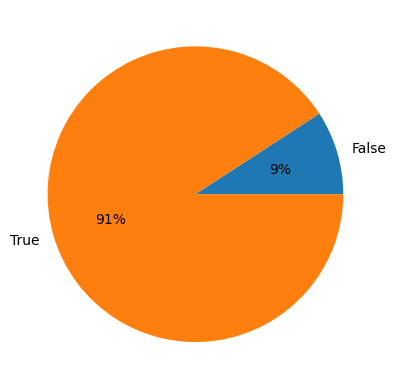

In [ ]:
df_cnn_lstm_prediction.groupby('cnn_lstm_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')



# Testing LSTM model on New Dataset

In [ ]:
#Loading LSTM Model
from tensorflow.keras.models import load_model

lstm_model = load_model('/content/drive/MyDrive/c1_lstm_model_acc_0.962.h5')

In [ ]:
sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews['Srn'] = np.arange(sample_reviews.shape[0])

sample_reviews.head(6)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,Srn
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",2
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",3
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",4
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht...",5


In [ ]:
# Pre-processing text

unseen_reviews = sample_reviews['reviews.text'] + sample_reviews['reviews.title']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

sample_reviews['Predicted Sentiments_lstm'] = np.round((unseen_sentiments*10)/2,1)


886/886 [==============================] - 35s 39ms/step


In [ ]:
df_lstm_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_lstm']]

df_lstm_prediction.head(10)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_lstm
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,5.0
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0
5,5,AmazonBasics AAA Performance Alkaline Batterie...,Bought a lot of batteries for Christmas and th...,5,5.0
6,6,AmazonBasics AAA Performance Alkaline Batterie...,ive not had any problame with these batteries ...,5,5.0
7,7,AmazonBasics AAA Performance Alkaline Batterie...,Well if you are looking for cheap non-recharge...,5,5.0
8,8,AmazonBasics AAA Performance Alkaline Batterie...,These do not hold the amount of high power jui...,3,5.0
9,9,AmazonBasics AAA Performance Alkaline Batterie...,AmazonBasics AA AAA batteries have done well b...,4,5.0


In [ ]:
df_lstm_prediction['reviews.rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['LSTM_Predicted.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['lstm_vs_actual'] = df_lstm_prediction['reviews.rating_sentiment'] == df_lstm_prediction['LSTM_Predicted.rating_sentiment']

df_lstm_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_lstm,reviews.rating_sentiment,LSTM_Predicted.rating_sentiment,lstm_vs_actual
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0,positive,negative,False
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,5.0,positive,positive,True
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True


<Axes: >

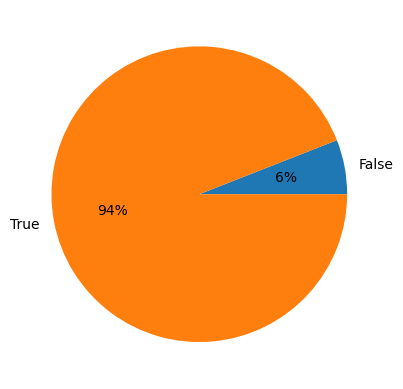

In [ ]:
df_lstm_prediction.groupby('lstm_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

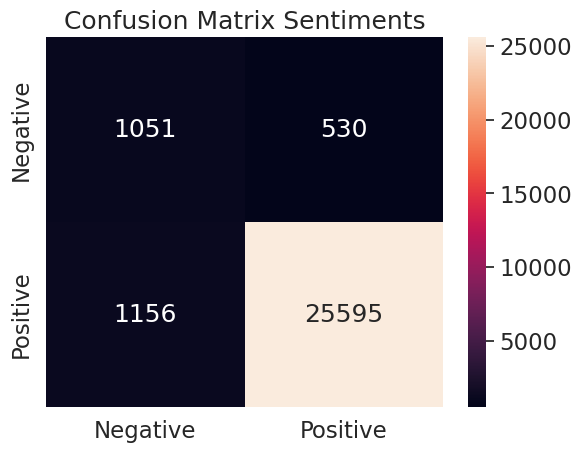

In [ ]:
C_M = confusion_matrix(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix Sentiments")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_LSTM_newdata = accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Balanced_accuracy_LSTM_newdata = balanced_accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Precision_LSTM_newdata = precision_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
Recall_LSTM_newdata = recall_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
F1_score_LSTM_newdata = f1_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_LSTM_newdata = Recall_LSTM_newdata
specificity_LSTM_newdata =  C_M[0][0] / (C_M[0][0] + C_M[0][1]) 


In [ ]:
print(Accuracy_LSTM_newdata)
print(Balanced_accuracy_LSTM_newdata)
print(Precision_LSTM_newdata)
print(Recall_LSTM_newdata)
print(F1_score_LSTM_newdata)
print(sensitivity_LSTM_newdata)
print(specificity_LSTM_newdata)

0.9404913172384582
0.8107778978203444
0.9516162481356331
0.9404913172384582
0.9450562191325741
0.9404913172384582
0.6647691334598356


# Testing CNN model on New Dataset

In [ ]:
#Loading CNN Model
from tensorflow.keras.models import load_model

cnn_model = load_model('/content/drive/MyDrive/c1_cnn_model_acc_0.97.h5')


In [ ]:
sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews['Srn'] = np.arange(sample_reviews.shape[0])

sample_reviews.head(6)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,Srn
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",2
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",3
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",4
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht...",5


In [ ]:
# Pre-processing text

unseen_reviews = sample_reviews['reviews.text'] + sample_reviews['reviews.title']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = cnn_model.predict(unseen_padded)

sample_reviews['Predicted Sentiments_cnn'] = np.round((unseen_sentiments*10)/2,1)


886/886 [==============================] - 7s 8ms/step


In [ ]:
df_cnn_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_cnn']]

df_cnn_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_cnn
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.5
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.9
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0


In [ ]:
df_cnn_prediction['reviews.rating_sentiment'] = df_cnn_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['CNN_Predicted.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments_cnn'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['cnn_vs_actual'] = df_cnn_prediction['reviews.rating_sentiment'] == df_cnn_prediction['CNN_Predicted.rating_sentiment']

df_cnn_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_cnn,reviews.rating_sentiment,CNN_Predicted.rating_sentiment,cnn_vs_actual
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.5,positive,negative,False
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.9,positive,positive,True
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True


<Axes: >

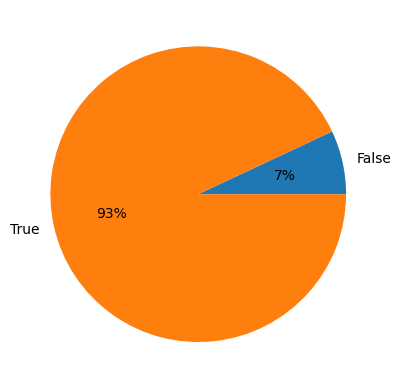

In [ ]:
df_cnn_prediction.groupby('cnn_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

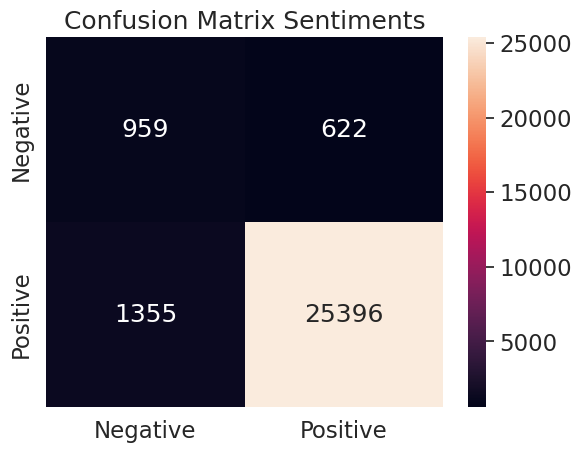

In [ ]:
C_M = confusion_matrix(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix Sentiments")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_CNN_newdata = accuracy_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])
Balanced_accuracy_CNN_newdata = balanced_accuracy_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])
Precision_CNN_newdata = precision_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted')
Recall_CNN_newdata = recall_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted')
F1_score_CNN_newdata = f1_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_LSTM_newdata = Recall_LSTM_newdata
specificity_LSTM_newdata =  C_M[0][0] / (C_M[0][0] + C_M[0][1]) 


print(Accuracy_CNN_newdata)
print(Balanced_accuracy_CNN_newdata)
print(Precision_CNN_newdata)
print(Recall_CNN_newdata)
print(F1_score_CNN_newdata)
print(sensitivity_LSTM_newdata)
print(specificity_LSTM_newdata)



0.9302202456586193
0.7779629015269571
0.9447513935368419
0.9302202456586193
0.936301525286603
0.9404913172384582
0.6065781151170145


# Merging Prediction based on LSTM_CNN for EDA

In [ ]:
df_cnn_LSTM = pd.merge(df_cnn_prediction,df_lstm_prediction,on='Srn')

In [ ]:
df_cnn_LSTM.to_csv("./drive/MyDrive/Prediction_LSTM_CNN.csv", sep=',', encoding='UTF-8')
